# Process for splitting data into training and testing

The following process consist of reading the csv file for the training data and from these images try to split a part to a test batch for traning and testing the model. This is only needed once, but we use random state to allows look for the same amount of images in each batch.

In [10]:
import numpy as np
import pandas as pd
import matplotlib

In [2]:
data = pd.read_csv('train.csv')
data.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
label = data.loc[:,'cancer']
label

0        0
1        0
2        0
3        0
4        0
        ..
54701    0
54702    0
54703    0
54704    0
54705    0
Name: cancer, Length: 54706, dtype: int64

In [4]:
image_path = "C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA_SS/Cancer_de_Mama_IA_SS_2023/data/raw_images/"

# Auxiliary function for cnoncatenating the image path
def concat_img_path( patient_id, image_id, img_path = image_path):
    image_path = img_path + str(patient_id) + "_" + str(image_id) + ".png"
    return image_path

# This function will clean the data in order to contain only image path and label
def clean_data(data):
    new_data = data[['cancer']].copy()
    new_data.rename(columns={'cancer': "label"}, inplace=True)
    images_path = []
    for i in range(len(data)):
        image = concat_img_path(data["patient_id"][i], data["image_id"][i])
        images_path.append(image)
    
    new_data['images_path'] = images_path
    new_data = new_data[['images_path', 'label']]
    return new_data    


In [5]:
data_to_split = clean_data(data)
data_to_split.head(10)

,images_path,label
0,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
1,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
2,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
3,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
4,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
5,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
6,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
7,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
8,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0
9,C:/Users/pedro/OneDrive/Escritorio/Proyecto_IA...,0


In [6]:
len(data_to_split) 

54706

## Using TensorFlow to read and decode the csv files

In [7]:
# Process for splitting the data
np.random.seed(10)
rnd = np.random.rand(len(data_to_split))
train = data_to_split[ rnd < 0.8  ]
test = data_to_split[ (rnd >= 0.8)]
print(len(data_to_split), len(train), len(test))

54706 43833 10873


In [8]:
# Saving into csv files 
train.to_csv('new_train.csv', header=False, index=False)
test.to_csv('new_test.csv', header=False, index=False)

In [2]:
import tensorflow as tf

In [3]:
def read_and_decode(filename):
  # 1-> Read the file
  img = tf.io.read_file(filename)
  # 2-> Convert compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # 3-> Convert 3D uint8 to floats in the range [0,1]
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

def decode_csv(csv_row):
  record_defaults = ["filepaths", "labels"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename)
  # label = tf.math.equal(CLASS_NAMES, label_string)
  return img, label_string

dataset = (tf.data.TextLineDataset(
    "new_train.csv").
    map(decode_csv))

In [4]:
for img, label in dataset.take(5):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) # average pixel in the image
  print(label, avg)

tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.06334462 0.06334462 0.06334462], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.10289186 0.10289186 0.10289186], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.09715645 0.09715645 0.09715645], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.05162391 0.05162391 0.05162391], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.09223529 0.09223529 0.09223529], shape=(3,), dtype=float32)


Tensors readed successfully!

In [11]:
# Plot some images

def plot_images(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(35,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    ax[idx//5, idx%5].axis('off')


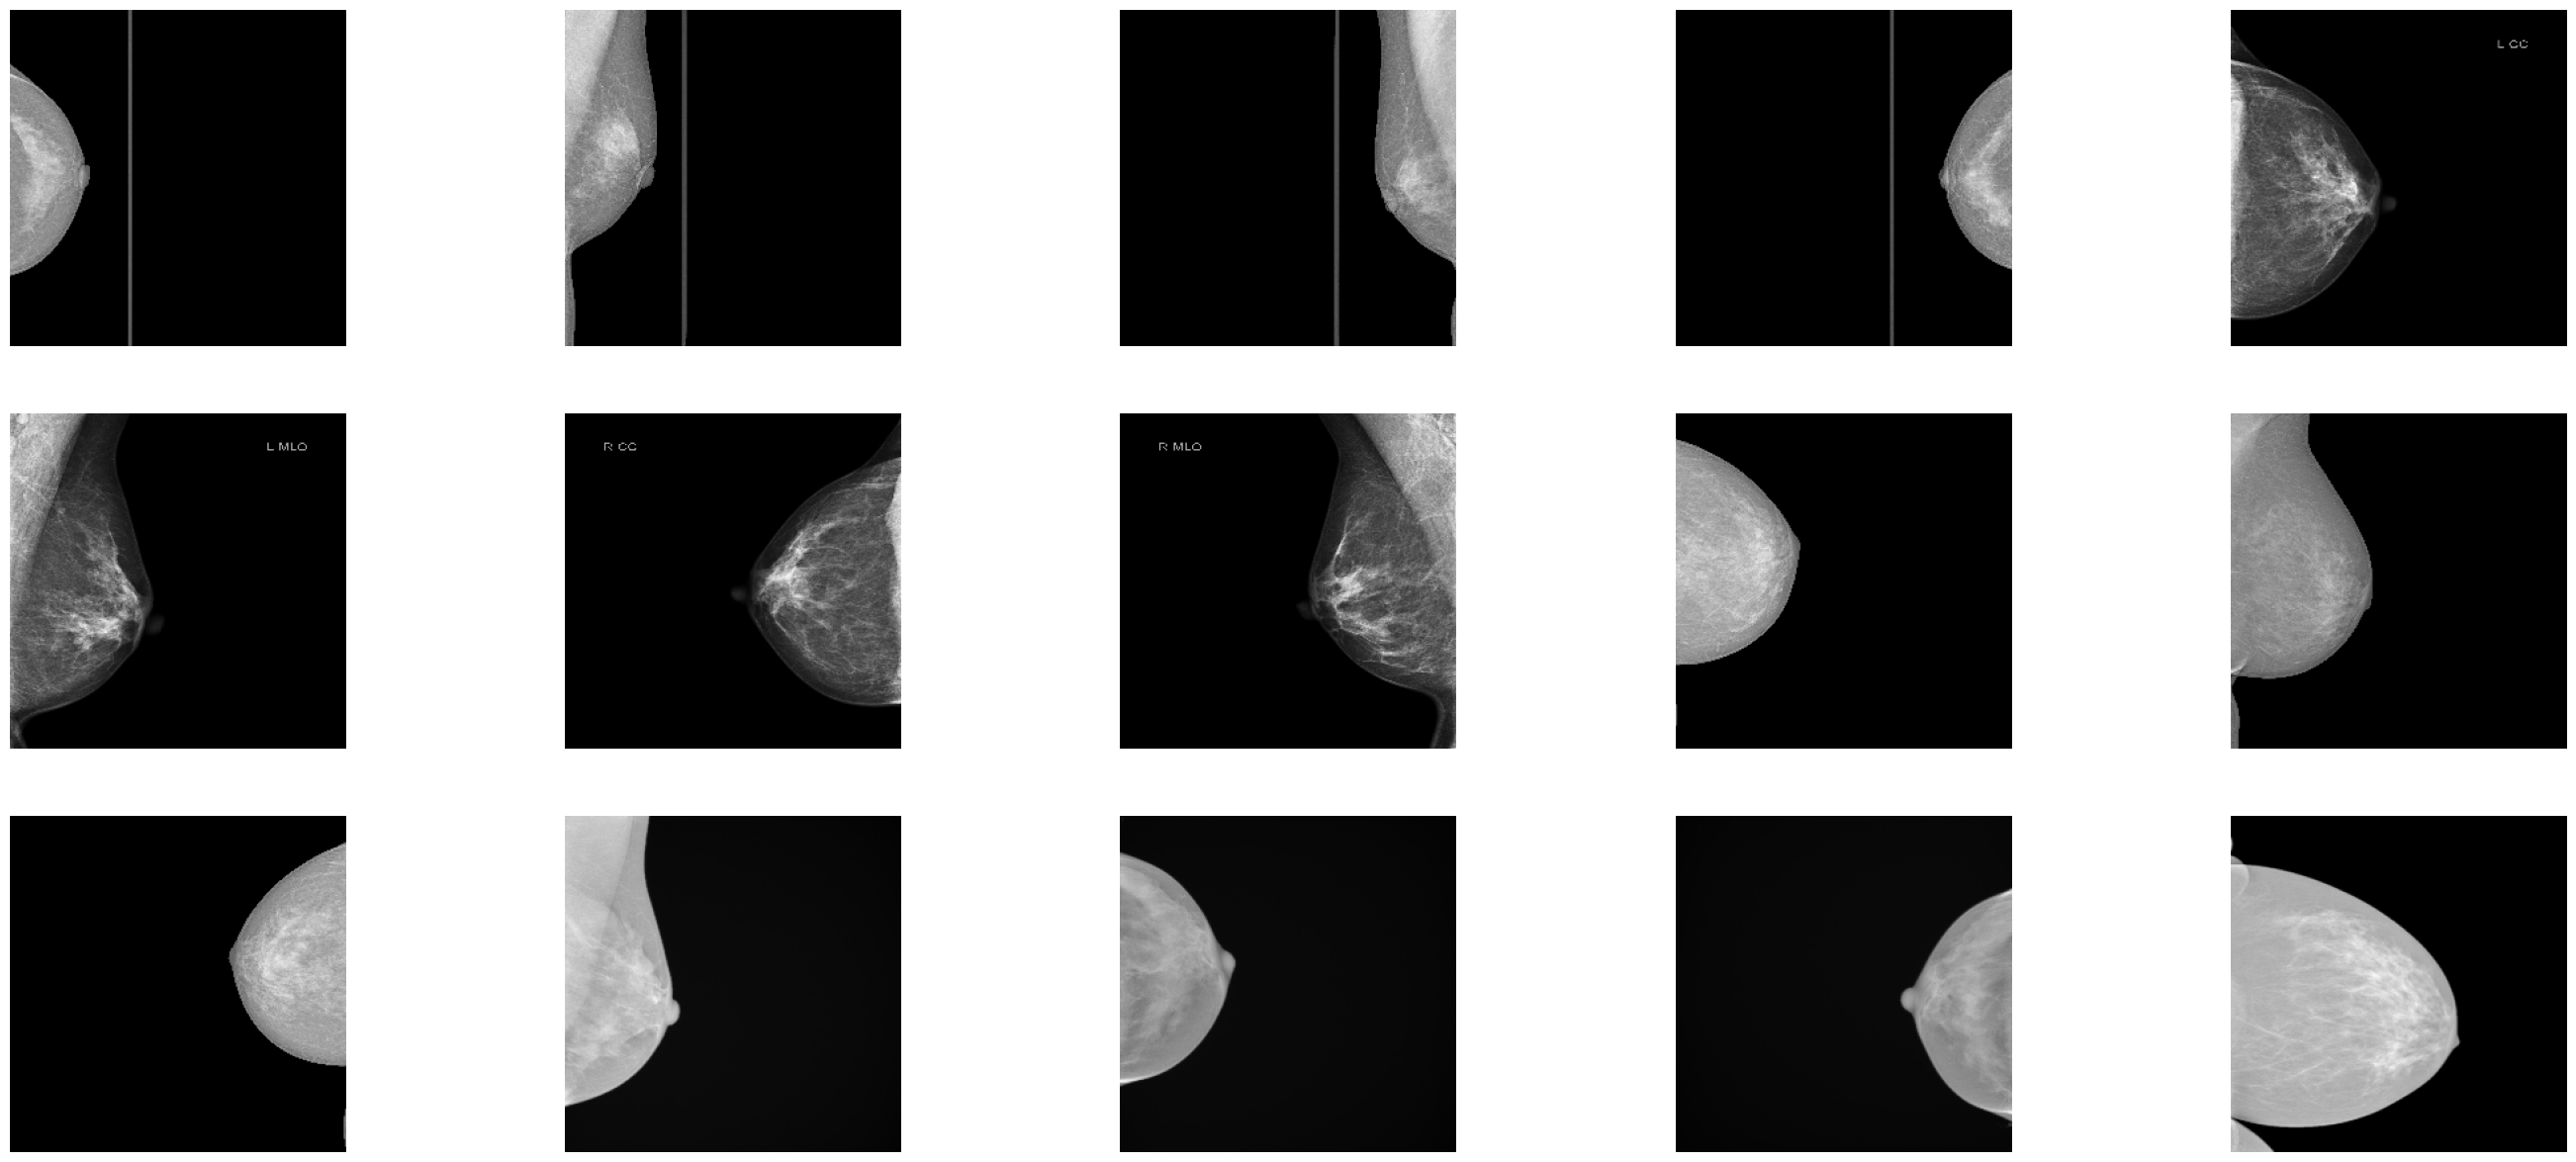

In [12]:
plot_images("new_train.csv")